In [31]:
import numpy as np
from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Load the 20NewsGroups dataset and see what it looks like 

In [32]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])


len(newsgroups_labels) 5616
newsgroups_labels [0 1 8 ... 8 1 2]
data_cleaned[1] .  Why, or how actually, can a Powerbook have a  x  pixel
    display, regardless if it is a " or ", and still keep the
     dpi resolution?  (I assume that it doesn't, and I don't 
    mean to imply they *all* have these dimensions)


.  Any info on price drops or new models (non-Duo) coming up?


newsgroups_labels[1] 1


In [33]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
# vectorizer = CountVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

for i in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][i]
    print('>>>> %i th coordinate <===> %s' % (idx, idx_to_word[idx]))



>>>> vectors.shape (45534, 5616)
newsgroups_labels[i] 1
>>>> data_cleaned[i] Anyone know what would cause my IIcx to not turn on when I hit the keyboard
switch?  The one in the back of the machine doesn't work either...
The only way I can turn it on is to unplug the machine for a few minutes,
then plug it back in and hit the power switch in the back immediately...
Sometimes this doesn't even work for a long time...

I remember hearing about this problem a long time ago, and that a logic 
board failure was mentioned as the source of the problem...is this true?

>>>> vectors[:,i] 
   (19200, 0)	0.21770578963545104
  (42226, 0)	0.2335535077833251
  (14215, 0)	0.1705545578077599
  (4850, 0)	0.13819530598739005
  (30501, 0)	0.1713304673332507
  (25060, 0)	0.1354075888392444
  (37293, 0)	0.1358535653965605
  (1286, 0)	0.11512233881047579
  (23500, 0)	0.15881823826900263
  (39267, 0)	0.3218337929129972
  (19354, 0)	0.15503677262806054
  (25592, 0)	0.14569851367713704
  (41292, 0)	0.1147999187

## Data Preprocessing

In [34]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [35]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [36]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2], 
                                                                       vectorizer = 'bag-of-words',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
print('y_list', onehot2list(y_test))

!! X.shape (5616, 45534)
X_train.shape (1415, 45534)
X_test.shape (332, 45534)
y_train.shape (1415, 3)
y_test.shape (332, 3)
y_test [[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 

## Multiclass Logistic Regression 

In [37]:
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent 
        Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        k = Y.shape[1] # number of classes 
        if W0 is None:
            W0 = 2*np.random.rand(H.shape[0],k)-1 #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [38]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

In [39]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                idx = np.where(P_pred[i,:]==np.max(P_pred[i,:]))
                y_pred.append(np.random.choice(idx[0]))
                
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    print('!!! confusion_mx : \n ', confusion_mx)
    results_dict.update({'Confusion_mx':confusion_mx})
    
    return results_dict

!! X.shape (5616, 45534)


<ipython-input-37-263749036d71>:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


!! W.shape (45535, 2)
AUC ===> 0.935
Opt_threshold ===> 0.994
Accuracy ===> 0.886
Sensitivity ===> 0.852
Specificity ===> 0.933
Precision ===> 0.822
Fall_out ===> 0.148
Miss_rate ===> 0.067
Confusion matrix 
 ===> [[104  18]
 [  6  83]]


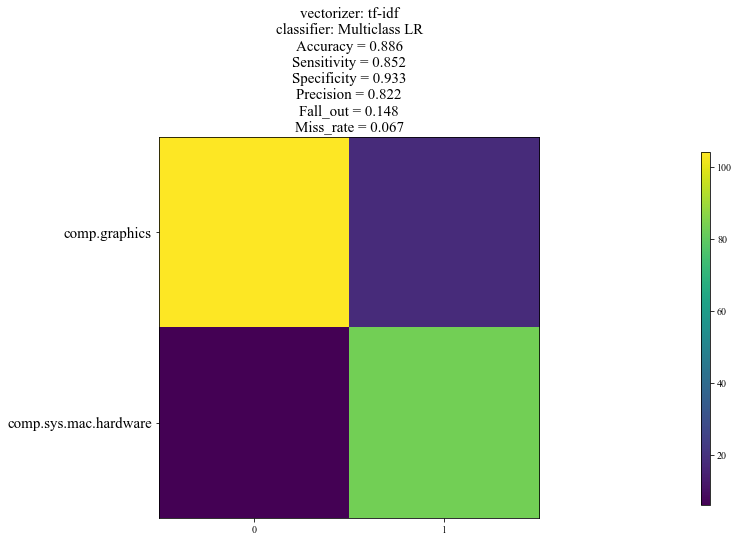

In [40]:
# fit multiclass logistic regression using GD

# list_vectorizer = ['tf-idf', 'bag-of-words']
list_vectorizer = ['tf-idf']
list_classes=[0, 1]
result_dict_list = []
W_list = []
    
for i in np.arange(len(list_vectorizer)):
    X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=list_classes, 
                                                                           vectorizer='bag-of-words', 
                                                                           full_data = None)
    # Feature matrix of size (p x n) = (feature dim x samples)
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
    W = fit_MLR_GD(Y=y_train, H=H_train) 
    print('!! W.shape', W.shape)

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

    if len(list_classes) == 2:
        results_dict = compute_accuracy_metrics(Y_test=onehot2list(y_test), P_pred=Q[:,1], verbose=True)
    else:
        results_dict = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q)
    result_dict_list.append(results_dict.copy())
    W_list.append(results_dict.get('Confusion_mx').copy())
    
# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_vectorizer), figsize=[12, 7])
class_labels= [data_dict.get('categories')[i] for i in list_classes]
for i in np.arange(len(list_vectorizer)):
    results_dict = result_dict_list[i]
    confusion_mx = results_dict.get('Confusion_mx')
    if len(list_vectorizer) > 1:
        im = ax[i].imshow(confusion_mx, vmin=np.min(W_list), vmax=np.max(W_list))
        ax[i].title.set_text("MLR Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax[i].set_xticks(np.arange(len(class_labels)))
        # ax[i].set_xticklabels(class_labels)
        ax[i].set_yticks(np.arange(len(class_labels)))
        ax[i].set_yticklabels(class_labels)
    else:
        im = ax.imshow(confusion_mx, vmin=np.min(W_list), vmax=np.max(W_list))
        ax.title.set_text("MLR Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_yticklabels(class_labels, fontsize='15')
    
    subtitle = "vectorizer: " + str(list_vectorizer[i]) + "\n" + "classifier: " + str('Multiclass LR')
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold', 'Confusion_mx']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_dict.get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
    ax.set_title(subtitle, fontsize='15')
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MLR_20News_ex1.pdf', bbox_inches='tight')


## Multinomial Naive Bayes Classifier

In [41]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

NameError: name 'H' is not defined

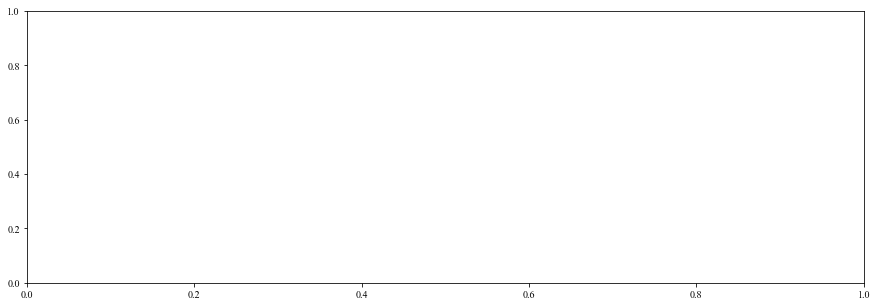

In [42]:
def fit_MNB(Y, H):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes 

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1)
        sub_H = H[:,idx[0]] + 1# add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

#test 
prior, class_conditional_PMF = fit_MNB(Y=y_train, H=X_train.T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
for i in [0,3]:
    ax.plot(np.arange(H.shape[0]), class_conditional_PMF[i], label=data_dict.get('categories')[i])
ax.legend(fontsize='15')
plt.suptitle("Class conditional PMFs", fontsize='15')

(227, 45534)
(2, 45534)


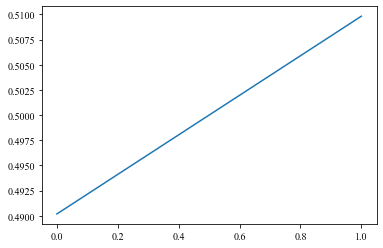

In [29]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    print(X_test.shape)
    print(class_conditional_PMF.shape)
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    return Q / sum_of_rows[:, np.newaxis]

# test 
predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
plt.plot(predictive_PMF[4])

In [ ]:
def plot_wordcloud(Y, H, idx2word, categories):
        # plot the class-conditioanl PMF as wordclouds 
        # Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        # idx2words = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
        
        class_conditional_PMF = []
        for i in np.arange(Y.shape[1]):
            idx = np.where(Y[:,i]==1)
            sub_H = H[:,idx[0]]
            word_count_per_class = np.sum(sub_H, axis=1)
            class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    
        ### topic mode
        num_word_sampling_from_topics = 10000
        
        fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(Y.shape[1])):
            dist = class_conditional_PMF[i]

            ### Randomly sample a word from the corpus according to the PMF "dist" multiple times
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            for j in range(num_word_sampling_from_topics):
                idx = np.random.choice(np.arange(H.shape[0]), p=dist)
                list_words.append(idx2word[idx])
                
            Y = " ".join(list_words)
            #stopwords = STOPWORDS
            #stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "19", "2019", "coronavirus",
            #                  "virus", "corona", "covid", "ncov", "covid19", "amp"])
            wordcloud = WordCloud(background_color="black",
                                  relative_scaling=0.1,
                                  width=400,
                                  height=400).generate(Y)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        plt.savefig('class_conditional_PMF_wordcloud_20News.pdf', bbox_inches='tight')

plot_wordcloud(Y=np.asarray(y_test), H=X_train.T, idx2word=idx2word, categories=categories)

In [ ]:
# fit multinomial naive Bayes

# list_vectorizer = ['tf-idf', 'bag-of-words']
list_vectorizer = ['bag-of-words']
list_classes=[0, 1, 2, 3, 4, 5, 6, 7, 9]
result_dict_list = []
W_list = []
    
for i in np.arange(len(list_vectorizer)):
    X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=list_classes, 
                                                                           vectorizer='bag-of-words', 
                                                                           full_data = None)
    # Feature matrix of size (p x n) = (feature dim x samples)
    prior, class_conditional_PMF = fit_MNB(Y=y_train, H=X_train.T) 
    Q = predict_MNB(X_test, prior, class_conditional_PMF)
   
    if len(list_classes) == 2:
        results_dict = compute_accuracy_metrics(Y_test=onehot2list(y_test), P_pred=Q[:,1], verbose=True)
    else:
        results_dict = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q)
    result_dict_list.append(results_dict.copy())
    W_list.append(results_dict.get('Confusion_mx').copy())
    
# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_vectorizer), figsize=[12, 7])
class_labels= [data_dict.get('categories')[i] for i in list_classes]
for i in np.arange(len(list_vectorizer)):
    results_dict = result_dict_list[i]
    confusion_mx = results_dict.get('Confusion_mx')
    if len(list_vectorizer) > 1:
        im = ax[i].imshow(confusion_mx, vmin=np.min(W_list), vmax=np.max(W_list))
        ax[i].title.set_text("MLR Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax[i].set_xticks(np.arange(len(class_labels)))
        # ax[i].set_xticklabels(class_labels)
        ax[i].set_yticks(np.arange(len(class_labels)))
        ax[i].set_yticklabels(class_labels)
    else:
        im = ax.imshow(confusion_mx, vmin=np.min(W_list), vmax=np.max(W_list))
        ax.title.set_text("MLR Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_yticklabels(class_labels, fontsize='15')
    
    subtitle = "vectorizer: " + str(list_vectorizer[i]) + "\n" + "classifier: " + str('Multinomial Naive Bayes')
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold', 'Confusion_mx']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_dict.get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
    ax.set_title(subtitle, fontsize='15')
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MNB_20News_ex1.pdf', bbox_inches='tight')